# VoxelMorph

A playground to have fun in

In [42]:
from __future__ import annotations
from collections import defaultdict
from importlib import reload
import matplotlib.pyplot as plt
import neurite as ne
import numpy as np
import os; os.environ['VXM_BACKEND'] = 'pytorch'
from pathlib import Path
import sys
from time import perf_counter
import torch
import torchvision
from tqdm import tqdm 
import random
import voxelmorph as vm
print(sys.version)
print('numpy version', np.__version__)
print('torch version', torch.__version__)
print(f'voxelmorph using {vm.py.utils.get_backend()} backend')

3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
numpy version 1.21.2
torch version 1.11.0
voxelmorph using pytorch backend


## datasets

* [mnist](https://pytorch.org/vision/stable/datasets.html)
* [fashionmnist](https://pytorch.org/vision/stable/datasets.html)
* [omniglot](https://pytorch.org/vision/stable/datasets.html)
* [morphomnist](https://github.com/dccastro/Morpho-MNIST)
* [caltech 101 silhouettes](https://people.cs.umass.edu/~marlin/data.shtml)

In [2]:
data_dir = Path('datasets')
data_dir.mkdir(exist_ok=True)

### Mnist

In [3]:
mnist_dir = data_dir / 'mnist'
mnist_dir.mkdir(exist_ok=True)
mnist = torchvision.datasets.MNIST(root=mnist_dir, download=True)

### Fashionmnist

In [4]:
fashionmnist_dir = data_dir / 'fashionmnist'
fashionmnist_dir.mkdir(exist_ok=True)
fashionmnist = torchvision.datasets.FashionMNIST(root=fashionmnist_dir, download=True)

### Omniglot

In [5]:
omniglot_dir = data_dir / 'omniglot'
omniglot_dir.mkdir(exist_ok=True)
omniglot = torchvision.datasets.Omniglot(root=omniglot_dir, download=True)

Files already downloaded and verified


### partition by class

In [6]:
def filter_by_class(data, labels, class_to_keep: int = 0):
    indexer = labels == class_to_keep
    filtered_data = data[indexer]
    filtered_labels = labels[indexer]
    return filtered_data, filtered_labels

def partition_by_class(data, labels, classes):
    class_partitions = {}
    for k in classes:
        class_partitions[k] = filter_by_class(data, labels, k)
    return class_partitions
       

In [7]:
mnist_data = mnist.data.numpy()
mnist_labels = mnist.targets.numpy()
mnist_classes = np.unique(mnist_labels)
mnist_partitions = partition_by_class(mnist_data, mnist_labels, mnist_classes)

In [8]:
fashionmnist_data = fashionmnist.data.numpy()
fashionmnist_labels = fashionmnist.targets.numpy()
fashionmnist_classes = np.unique(fashionmnist_labels)
fashionmnist_partitions = partition_by_class(fashionmnist_data, fashionmnist_labels, fashionmnist_classes)

### split data

In [9]:
def get_data_split(data, labels, val_split=0.1, test_split=0.2):
    data = np.asarray(data)
    labels = np.asarray(labels)
    n = data.shape[0]
    assert n == labels.shape[0]
    index = list(range(n))
    random.shuffle(index)
    num_test = round(test_split * n)
    num_dev = n - num_test
    num_val = round(num_dev * val_split)
    num_train = num_dev - num_val
    train_index = index[:num_train]
    val_index = index[num_train:num_train+num_val]
    test_index = index[-num_test:]
    return {
        'train_data': data[train_index],
        'train_labels': labels[train_index],
        'val_data': data[val_index],
        'val_labels': labels[val_index],
        'test_data': data[test_index],
        'test_labels': labels[test_index],
    }

In [10]:
five_data = mnist_partitions[5]
five_split = get_data_split(*five_data)

In [11]:
sneaker_data = fashionmnist_partitions[7]
sneaker_split = get_data_split(*sneaker_data)

### dataset class

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        data: np.ndarray, 
        labels: np.ndarray, 
        normalize: bool = True,
        padding: None | tuple[int, int] = (32, 32), 
        transforms: None | list[torchvision.transforms] = [
            # torchvision.transforms.Pad((32, 32), fill=0),
            torchvision.transforms.ToTensor(),
        ],
    ):
        self.data = data
        self.labels = labels
        self.normalize = normalize
        self.padding = padding
        self.transforms = torchvision.transforms.Compose(transforms)

    def __len__(self):
        return self.data.shape[0] - 1

    def __getitem__(self, index):
        image_m = self.data[index]
        image_f = self.data[index+1]
        # label_m = self.labels[index+1]
        # label_f = self.labels[index]
        if self.transforms:
            image_m = self.transforms(image_m)
            image_f = self.transforms(image_f)
        if self.padding:
            image_m = self.pad(image_m)
            image_f = self.pad(image_f)
            
        return torch.cat([image_m, image_f], 0)
    
    def normalize(self, image):
        pass
    
    def pad(self, image):
        # only handles case when pad > size
        w, h = image.squeeze().shape
        assert self.padding[0] >= w, 'width padding too small'
        assert self.padding[1] >= h, 'height padding too small'
        w_diff = self.padding[0] - w
        h_diff = self.padding[1] - h
        w_pad = w_diff // 2
        h_pad = h_diff // 2
        padding = w_pad, w_diff - w_pad, h_pad, h_diff - h_pad
        image = torch.nn.functional.pad(image, padding, 'constant', 0)
        return image

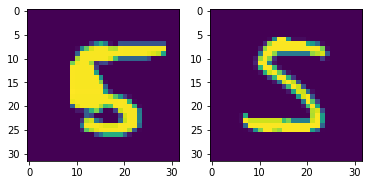

In [13]:
five_train_dataset = Dataset(five_split['train_data'], five_split['train_labels'])
five_val_dataset = Dataset(five_split['val_data'], five_split['val_labels'])
five_test_dataset = Dataset(five_split['test_data'], five_split['test_labels'])

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(five_train_dataset[0][0])
ax[1].imshow(five_train_dataset[0][1])

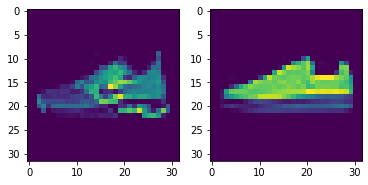

In [14]:
sneaker_train_dataset = Dataset(sneaker_split['train_data'], sneaker_split['train_labels'])
sneaker_val_dataset = Dataset(sneaker_split['val_data'], sneaker_split['val_labels'])
sneaker_test_dataset = Dataset(sneaker_split['test_data'], sneaker_split['test_labels'])
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(sneaker_train_dataset[0][0])
ax[1].imshow(sneaker_train_dataset[0][1])

### build dataloaders

In [15]:
def get_dataloader(
    dataset: torch.utils.data.Dataset,
    batch_size: int=32,
    shuffle=True,
    pin_memory=True,
):
    return torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        pin_memory=pin_memory,
    )

In [16]:
five_train_loader = get_dataloader(five_train_dataset)
five_val_loader = get_dataloader(five_val_dataset)
five_test_loader = get_dataloader(five_test_dataset)

sneaker_train_loader = get_dataloader(sneaker_train_dataset)
sneaker_val_loader = get_dataloader(sneaker_val_dataset)
sneaker_test_loader = get_dataloader(sneaker_test_dataset)

In [17]:
next(iter(five_train_loader)).shape

torch.Size([32, 2, 32, 32])

## model

In [18]:
inshape = (32, 32)
infeats = 1
unet = vm.networks.Unet(inshape=inshape, infeats=infeats)

In [19]:
unet(next(iter(sneaker_train_loader))[:, 0].unsqueeze(1)).shape

torch.Size([32, 16, 32, 32])

In [20]:
img = next(iter(sneaker_train_loader))

In [21]:
img.shape

torch.Size([32, 2, 32, 32])

In [23]:
conv_layer = torch.nn.Conv2d(16, 2, 3, padding=1)
spatial_transformer = vm.layers.SpatialTransformer(inshape)
moving_image = img[:, 0].unsqueeze(1)
displacement = conv_layer(unet(moving_image))
moved_image = spatial_transformer(moving_image, displacement)

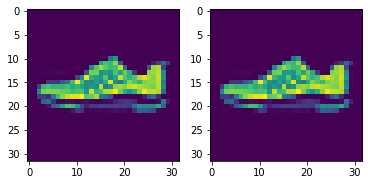

In [24]:
fig, ax= plt.subplots(ncols=2)
ax[0].imshow(img[0][0].detach().numpy())
ax[1].imshow(moved_image[0][0].detach().numpy())

In [25]:
class Model(torch.nn.Module):
    def __init__(
        self,
        image_size: tuple[int, int] | tuple[int, int, int],
        input_channels: int = 1,
    ):
        super().__init__()
        self.image_size = image_size
        self.input_channels= input_channels
        self.ndim = len(image_size)
        self.unet = vm.networks.Unet(inshape=image_size, infeats=input_channels)
        self.flow = getattr(torch.nn, f'Conv{self.ndim}d')(16, 2, 3, padding=1)
        self.spatial_transformer = vm.layers.SpatialTransformer(image_size)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        displacement = self.flow(self.unet(x))
        moved_image = self.spatial_transformer(x, displacement)
        return moved_image, displacement

In [40]:
model = Model((32, 32))

### loss function

In [31]:
mse = vm.losses.MSE()
grad = vm.losses.Grad('l2')

def loss_func(fixed, moving, displacement, weight=0.05):
    mse_loss = mse.loss(fixed, moving)
    grad_loss = grad.loss(displacement)
    return mse_loss + weight*grad_loss

In [32]:
moving_image = img[:, 0].unsqueeze(1)
fixed_image = img[:, 1].unsqueeze(1)
prediction, displacement = model(moving_image)
loss_func(fixed_image, moved_image, displacement)

tensor(0.0563, grad_fn=<AddBackward0>)

### training

In [47]:
# model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [44]:
def iterate(
    model,
    loader,
    training: bool = True,
):
    average_loss = 0.
    for i, images in tqdm(enumerate(loader)):
        fixed_images = images[:, 0].unsqueeze(1)
        moving_images = images[:, 1].unsqueeze(1)
        predictions, displacements = model(moving_images)
        loss = loss_func(fixed_images, predictions, displacements)
        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        average_loss += loss.detach().item()
    return average_loss / i
    

def train(
    model,
    train_loader,
    val_loader,
    epochs: int = 10,
):
    epoch_loss = defaultdict(list)
    for i in range(epochs):
        train_loss = iterate(model, train_loader)
        val_loss = iterate(model, val_loader, training=False)
        epoch_loss['train'].append(train_loss)
        epoch_loss['val'].append(val_loss)
        print(f'epoch {i} finished')

In [45]:
epoch_loss = train(model, sneaker_train_loader, sneaker_val_loader)

  0%|                                                                        | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
4it [00:00, 34.97it/s]
9it [00:00, 40.98it/s]
14it [00:00, 42.07it/s]
19it [00:00, 43.11it/s]
24it [00:00, 43.10it/s]
29it [00:00, 43.73it/s]
34it [00:00, 42.88it/s]
39it [00:00, 43.17it/s]
44it [00:01, 43.15it/s]
49it [00:01, 43.43it/s]
54it [00:01, 43.77it/s]
59it [00:01, 43.38it/s]
64it [00:01, 40.71it/s]
69it [00:01, 40.80it/s]
74it [00:01, 40.78it/s]
79it [00:01, 41.31it/s]
84it [00:01, 41.87it/s]
89it [00:02, 42.45it/s]
94it [00:02, 42.49it/s]
99it [00:02, 42.36it/s]
104it [00:02, 41.38it/s]
109it [00:02, 42.17it/s]
114it [00:02, 42.44it/s]
119it [00:02, 42.00it/s]
124it [00:02, 42.48it/s]
129it [00:03, 41.44it/s]
135it [00:03, 42.09it/s]

0it [00:00, ?it/s]
15it [00:00, 106.62it/s]
 10%|██████▍                                                         | 1/10 [00:03<00:30,  3.36s/it]
0it [00:00, ?it/s]
5it [00:00, 44.41it/s]
10it [00:00, 41.55it/s]
15it [00:00, 40

KeyboardInterrupt: 